## Topic Modeling with LDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import sys
#!{sys.executable} -m spacy download en
from pprint import pprint

In [3]:
#Install spacy and the English model if you haven't already:
#pip install spacy
#python -m spacy download en_core_web_sm

In [4]:
import gensim
import spacy
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
from gensim.models import LdaModel
from sklearn.model_selection import ParameterGrid

In [6]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['would','could','one','two'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to C:\Users\Darrin
[nltk_data]     DeYoung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv('Emirates_reviews.csv')
df.head()

,reviews,stars,date,country
0,✅ Trip Verified | I flew a return trip DXB-L...,5,12th August 2024,United Arab Emirates
1,✅ Trip Verified | We were 2 people travellin...,10,11th August 2024,India
2,"Not Verified | First time flying Emirates, w...",4,29th July 2024,Netherlands
3,✅ Trip Verified | Ground Staff and Service Fa...,5,18th July 2024,Singapore
4,Not Verified | The staff are friendly and the...,1,13th July 2024,Hong Kong


In [8]:
df = pd.read_csv('Emirates_reviews.csv')
df[['Verification', 'reviews']] = df['reviews'].str.split("|", expand = True)
df.head()

,reviews,stars,date,country,Verification
0,I flew a return trip DXB-LIS-DXB I used my ...,5,12th August 2024,United Arab Emirates,✅ Trip Verified
1,We were 2 people travelling together and on...,10,11th August 2024,India,✅ Trip Verified
2,"First time flying Emirates, was expecting a...",4,29th July 2024,Netherlands,Not Verified
3,Ground Staff and Service Failures on Flight ...,5,18th July 2024,Singapore,✅ Trip Verified
4,The staff are friendly and the seat is comfo...,1,13th July 2024,Hong Kong,Not Verified


In [9]:
print(df['reviews'].dtype)

object


In [10]:
#converting into string datatype 
df['reviews'] = df['reviews'].astype(str).str.lower()
df.head(3)

,reviews,stars,date,country,Verification
0,i flew a return trip dxb-lis-dxb i used my ...,5,12th August 2024,United Arab Emirates,✅ Trip Verified
1,we were 2 people travelling together and on...,10,11th August 2024,India,✅ Trip Verified
2,"first time flying emirates, was expecting a...",4,29th July 2024,Netherlands,Not Verified


### Preprocessing

In [11]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
#converts the 'reviews' column into a NumPy array.and then converts into a Python list.
data = df['reviews'].values.tolist() 
data_words = list(sent_to_words(data))
print(data_words[:1])

[['flew', 'return', 'trip', 'dxb', 'lis', 'dxb', 'used', 'my', 'miles', 'to', 'upgrade', 'to', 'business', 'class', 'on', 'the', 'outbound', 'journey', 'which', 'was', 'very', 'nice', 'experience', 'morning', 'flight', 'with', 'flat', 'bed', 'seat', 'lovely', 'crew', 'and', 'amazing', 'service', 'on', 'the', 'return', 'they', 'surprised', 'me', 'on', 'boarding', 'with', 'an', 'upgrade', 'to', 'business', 'class', 'even', 'though', 'it', 'was', 'the', 'middle', 'seat', 'it', 'didn', 'bother', 'me', 'they', 'provided', 'bulgari', 'amenities', 'kit', 'and', 'mattress', 'and', 'cover', 'after', 'delicious', 'meal', 'had', 'hrs', 'sleep', 'as', 'it', 'was', 'an', 'over', 'night', 'flight']]


In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [13]:
data_ready[0][:7]

['fly', 'return', 'trip', 'dxb', 'lis', 'dxb', 'use']

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [18]:
# Define parameter grid for Grid Search
param_grid = {
    'num_topics': [3, 5, 7],
    'alpha': ['symmetric', 'asymmetric'],
    'beta': ['symmetric']
}

def evaluate_lda_model(corpus, id2word, num_topics, alpha, beta):
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        alpha=alpha,
        eta=beta,
        random_state=100,
        passes=10,
        per_word_topics=True
    )
    
    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    return coherence_lda

# Perform Grid Search
best_score = float('-inf')
best_params = {}

for params in ParameterGrid(param_grid):
    coherence_score = evaluate_lda_model(corpus, id2word, params['num_topics'], params['alpha'], params['beta'])
    print(f"Params: {params} => Coherence Score: {coherence_score}")
    
    if coherence_score > best_score:
        best_score = coherence_score
        best_params = params

print("Best Parameters:", best_params)
print("Best Coherence Score:", best_score)

Params: {'alpha': 'symmetric', 'beta': 'symmetric', 'num_topics': 3} => Coherence Score: 0.4175861441465128
Params: {'alpha': 'symmetric', 'beta': 'symmetric', 'num_topics': 5} => Coherence Score: 0.41216462442148594
Params: {'alpha': 'symmetric', 'beta': 'symmetric', 'num_topics': 7} => Coherence Score: 0.39353852101127346
Params: {'alpha': 'asymmetric', 'beta': 'symmetric', 'num_topics': 3} => Coherence Score: 0.41893323591415044
Params: {'alpha': 'asymmetric', 'beta': 'symmetric', 'num_topics': 5} => Coherence Score: 0.401442356305466
Params: {'alpha': 'asymmetric', 'beta': 'symmetric', 'num_topics': 7} => Coherence Score: 0.3895887973047965
Best Parameters: {'alpha': 'asymmetric', 'beta': 'symmetric', 'num_topics': 3}
Best Coherence Score: 0.41893323591415044


#### alpha = 'asymmetric': This allows for different topics to have different prior probabilities in a document, providing more flexibility. For example, some documents might be more likely to cover specific topics than others.

#### beta = 'symmetric': This assumes that each topic has the same distribution over words, meaning every word has an equal prior probability of being associated with any topic. This often leads to a model where each topic has a balanced representation of words.

In [19]:
# Using the best parameters found
best_params = {'alpha': 'asymmetric', 'beta': 'symmetric', 'num_topics': 3}

# Train the LDA model with best parameters
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=best_params['num_topics'],
    alpha=best_params['alpha'],
    eta=best_params['beta'],
    random_state=100,
    passes=10,
    per_word_topics=True
)

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f"Trained LDA Model with Coherence Score: {coherence_lda}")

Trained LDA Model with Coherence Score: 0.41893323591415044


In [20]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.049*"none" + 0.021*"emirate" + 0.013*"flight" + 0.011*"bag" + 0.010*"airline" + 0.010*"luggage" + 0.009*"pay" + 0.009*"service" + 0.009*"check" + 0.008*"baggage"')
(1, '0.024*"flight" + 0.018*"emirate" + 0.018*"good" + 0.017*"crew" + 0.016*"seat" + 0.016*"service" + 0.015*"food" + 0.013*"cabin" + 0.011*"time" + 0.011*"class"')
(2, '0.037*"flight" + 0.024*"emirate" + 0.014*"seat" + 0.013*"get" + 0.012*"hour" + 0.012*"service" + 0.009*"time" + 0.008*"fly" + 0.008*"ask" + 0.007*"say"')


In [21]:
#!pip install pyLDAvis

In [22]:
import pyLDAvis
import pyLDAvis.gensim_models

# Prepare the visualization
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

# Display the visualization
pyLDAvis.display(vis)

C:\Users\Darrin DeYoung\anaconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Darrin DeYoung\anaconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


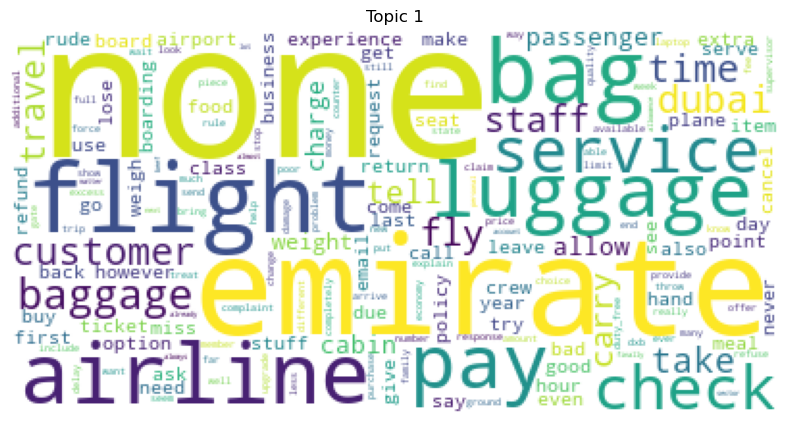

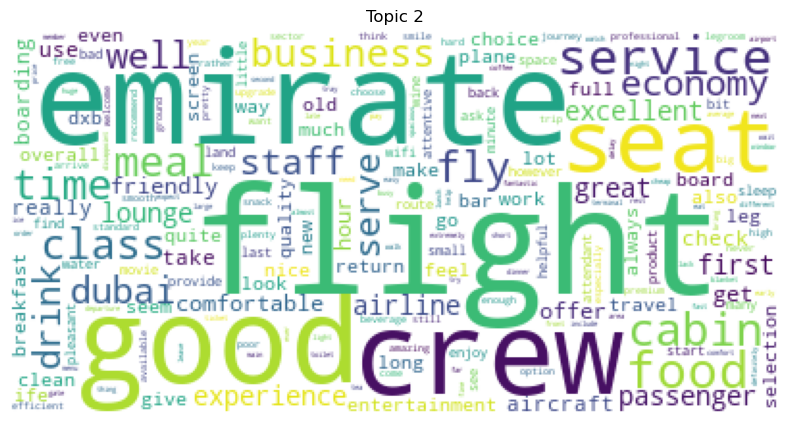

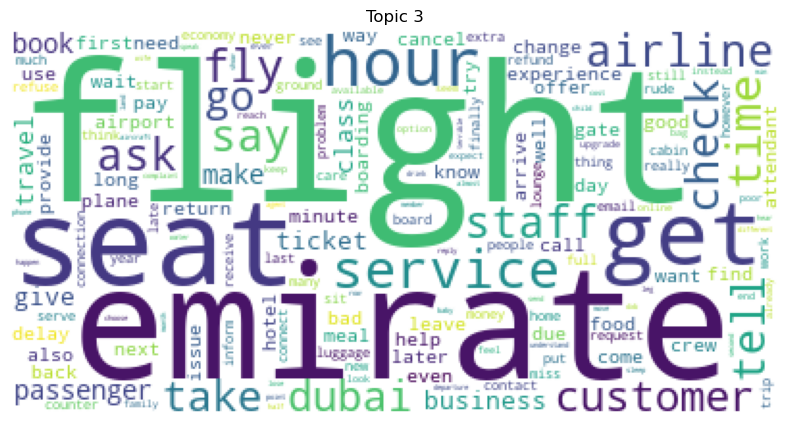

In [23]:
from wordcloud import WordCloud

def plot_wordcloud(lda_model, num_topics):
    for i in range(num_topics):
        plt.figure(figsize=(10, 5))
        plt.imshow(WordCloud(background_color='white').generate_from_frequencies(dict(lda_model.show_topic(i, 200))))
        plt.axis('off')
        plt.title(f'Topic {i+1}')
        plt.show()

plot_wordcloud(lda_model, num_topics=3)

warnings.filterwarnings('ignore', category=DeprecationWarning)